In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import QuantileTransformer


# READ DF + NORMALIZE

In [3]:
df = pd.read_csv("rfm_data.csv")
df.rename(columns = {'LAST_TO_END':'LAST_TO_END (R)', 'FLIGHT_COUNT':'FLIGHT_COUNT (F)', 'SEG_KM_SUM':'SEG_KM_SUM (M)'}, inplace=True)

quantile_trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
df_scaled = pd.DataFrame(quantile_trans.fit_transform(df), columns=df.columns)
df_scaled

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M)
0,-5.199338,5.199338,5.199338
1,-1.362078,3.205791,3.187548
2,-1.159515,3.185884,3.177664
3,-0.076604,1.097845,3.175353
4,-1.521525,3.259518,3.204363
...,...,...,...
62983,0.734798,-5.199338,-2.511791
62984,-0.119468,-0.489307,-0.201365
62985,-0.683178,-5.199338,-1.366221
62986,1.023003,-5.199338,-0.890172


# K-MEANS-LTS

In [4]:
# Return K_MEANS dengan cluster_id dan distance to centroid
def cluster_maker(dataframe, n_cluster_lts):
    kmeans = KMeans(n_clusters=n_cluster_lts, init='k-means++', random_state=42).fit(dataframe)

    dataframe['distance_to_centroid'] = np.min(kmeans.transform(dataframe), axis=1)
    dataframe['cluster_id'] = kmeans.labels_

    return dataframe

In [5]:
# Memisahkan dataframe & mengurutkan berdasarkan distance
def separate_dataframe(dataframe, n_cluster_lts, sort_column='distance_to_centroid'):
    cluster_dfs = {}

    for i in range(n_cluster_lts):
        cluster_dfs[i] = [dataframe[dataframe['cluster_id'] == i]]
        cluster_dfs[i][0] = cluster_dfs[i][0].sort_values(sort_column, ascending=False)
        
    return cluster_dfs

In [6]:
def KMeans_LTS(df, n_cluster_lts, n_percent):
    clustered_df = cluster_maker(df, n_cluster_lts)
    cluster_dict = separate_dataframe(clustered_df, n_cluster_lts)
    inliers_dfs = []
    outliers_dfs = []

    for cluster_id, df_list in cluster_dict.items():
        # Mengurutkan DataFrame berdasarkan distance_to_centroid secara descending
        sorted_df = df_list[0].sort_values(by='distance_to_centroid', ascending=False)

        # Menghitung jumlah baris yang akan di-trim
        n_rows_to_trim = int(n_percent / 100 * len(sorted_df))

        # Memisahkan inliers dan outliers
        inliers_df = sorted_df.iloc[n_rows_to_trim:]
        outliers_df = sorted_df.iloc[:n_rows_to_trim]

        # Menambahkan cluster_id-out ke outliers
        outliers_df.loc[:, outliers_df.columns.isin(['cluster_id'])] = str(cluster_id) + '-out'

        # Menyimpan DataFrame inliers dan outliers
        inliers_dfs.append(inliers_df)
        outliers_dfs.append(outliers_df)

    # Menggabungkan DataFrame inliers dari semua cluster sesuai dengan index awal
    inliers_result = pd.concat(inliers_dfs).drop(columns=['distance_to_centroid']).sort_index()

    # Menggabungkan DataFrame outliers dari semua cluster
    outliers_result = pd.concat(outliers_dfs).drop(columns=['distance_to_centroid']).sort_index()

    # Return hasil clustering inliers+outliers sesuai dengan index awal
    optimal_cluster = pd.concat([inliers_result, outliers_result], axis=0).sort_index()

    return inliers_result, optimal_cluster

# TEST K-MEANS LTS ALGORITHM with K = 2 and n_percentage = 10

c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)


<Figure size 800x800 with 0 Axes>

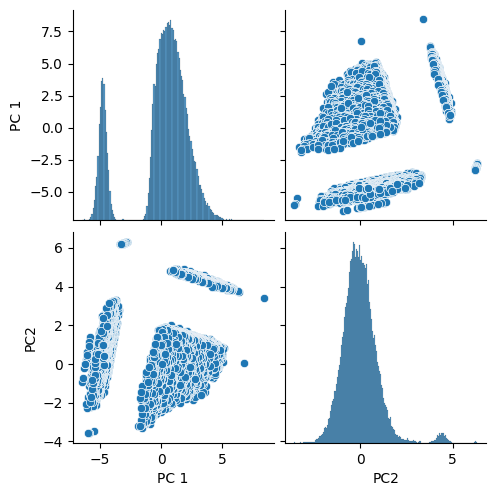

<Figure size 800x800 with 0 Axes>

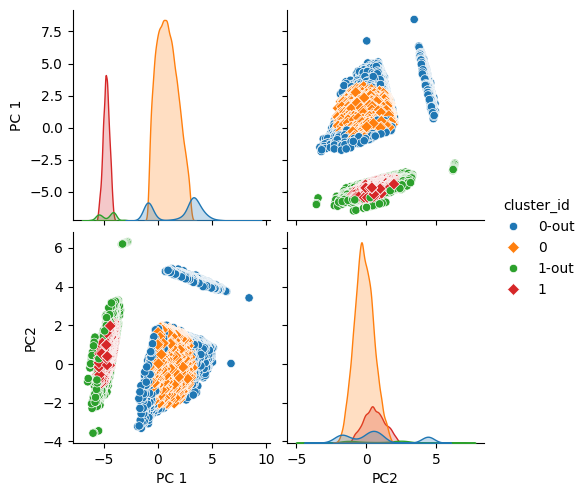

<Figure size 800x800 with 0 Axes>

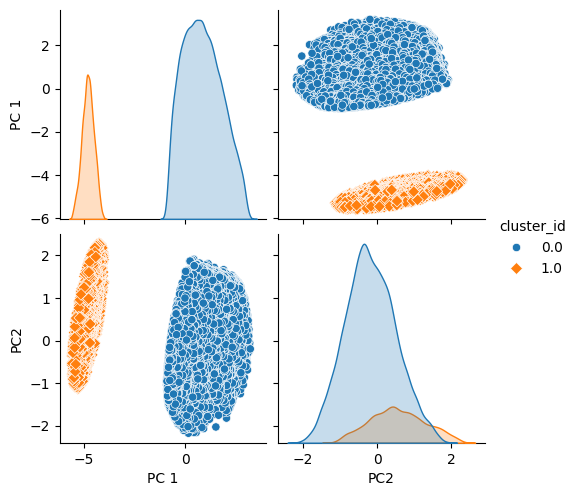

In [7]:
# TEST VISUALIZATION
from sklearn.decomposition import PCA
import seaborn as sns 

# PCA variable input
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca)

# GET inliers (LTS_result_filtered) and optimal cluster (LTS_result)
test_df = df_scaled.copy()
LTS_result_filtered, LTS_result = KMeans_LTS(test_df, 2, 10)

# PAIR PLOT with OUTLIERS
df_pca['cluster_id'] = LTS_result.loc[:, LTS_result.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

#PAIR PLOT without OUTLIERS
df_pca['cluster_id'] = LTS_result_filtered.loc[:, LTS_result_filtered.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

In [8]:
# FIND SILHOUETTE SCORE
from sklearn.metrics import silhouette_score

inliers_no_id = LTS_result_filtered.drop(['cluster_id'], axis=1)
score = silhouette_score(inliers_no_id, LTS_result_filtered['cluster_id'])
print(score)

0.7352291757984215


In [9]:
# Davies Bouldin Score

from sklearn.metrics import davies_bouldin_score

inliers_no_id = LTS_result_filtered.drop(['cluster_id'], axis=1)
score = davies_bouldin_score(inliers_no_id, LTS_result_filtered['cluster_id'])
print(score)

0.35137477511668386


In [10]:
# FIND SILHOUETTE SCORE untuk HASIL CLUSTER dari INLIERS saja
inliers_cluster = KMeans(n_clusters=2, init='k-means++', random_state=42).fit(inliers_no_id)
score = silhouette_score(inliers_no_id, inliers_cluster.labels_)
print(score)

c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.7352291757984215


In [11]:
# Davies Bouldin Score INLIERS SAJA

inliers_cluster = KMeans(n_clusters=2, init='k-means++', random_state=42).fit(inliers_no_id)
score = davies_bouldin_score(inliers_no_id, inliers_cluster.labels_)
print(score)

0.35137477511668386


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# K and PERCENTAGE OPTIMIZATIONS

In [12]:
def best_percentage(dataframe, n_cluster_lts):
    best_silhouette_score = 0
    best_percent = 0
    best_inliers = None
    best_cluster = None

    for percent in range(5, 35, 5):
        print("PERCENT:", percent)
        inliers, optimal_cluster = KMeans_LTS(dataframe, n_cluster_lts=n_cluster_lts, n_percent=percent)

        score = silhouette_score(inliers.iloc[:, :-1], inliers['cluster_id'])
        print("Score:", score)

        if score > best_silhouette_score:
            best_silhouette_score = score
            best_percent = percent
            best_inliers = inliers
            best_cluster = optimal_cluster
    
    print("====================================================")
    print("Best Silhouette Score:", best_silhouette_score)
    print("Best Percent:", best_percent)

    return best_inliers, best_cluster

test_df = df_scaled.copy()
best_inliers, best_cluster = best_percentage(test_df, 2)

PERCENT: 5


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Score: 0.7193431383317629
PERCENT: 10


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Score: 0.7352291757984215
PERCENT: 15


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Score: 0.7488394146169522
PERCENT: 20


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Score: 0.7611262275649742
PERCENT: 25


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Score: 0.7730048874281171
PERCENT: 30


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Score: 0.7844083490782578
Best Silhouette Score: 0.7844083490782578
Best Percent: 30


In [13]:
# Davies Bouldin Score INLIERS SAJA

score = davies_bouldin_score(best_inliers.drop('cluster_id', axis=1), best_inliers['cluster_id'])
print(score)

0.28391639655577694


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)


<Figure size 800x800 with 0 Axes>

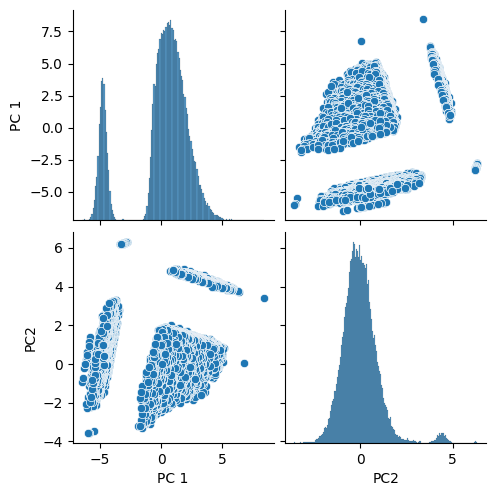

<Figure size 800x800 with 0 Axes>

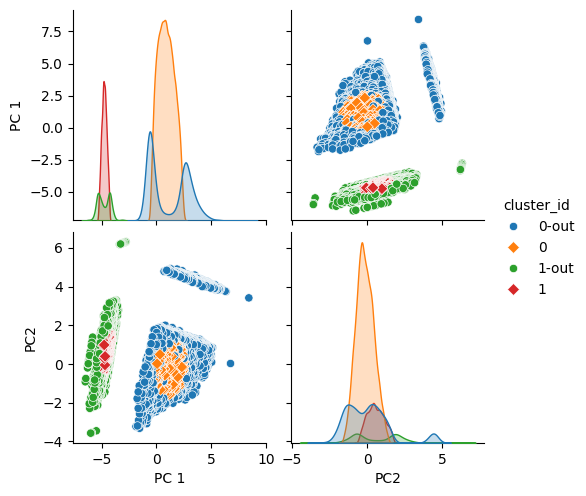

<Figure size 800x800 with 0 Axes>

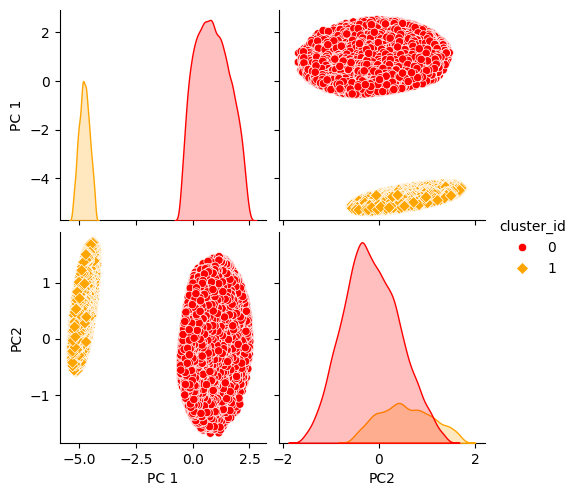

In [14]:
# OPTIMAL VISUALIZATION
from sklearn.decomposition import PCA
import seaborn as sns 

# PCA variable input
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca)

# PAIR PLOT OPTIMAL with OUTLIERS
df_pca['cluster_id'] = best_cluster.loc[:, best_cluster.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])


# PAIR PLOT OPTIMAL without OUTLIERS
df_pca['cluster_id'] = best_inliers.loc[:, best_inliers.columns.isin(['cluster_id'])]
df_pca.dropna(inplace=True)
df_pca['cluster_id'] = df_pca['cluster_id'].astype(int)

# df_pca.info()
plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"], palette=["red", "orange"])